<a href="https://colab.research.google.com/github/davidrichardharvey/learning_tensorflow/blob/main/fcc_cat_dog_58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containng both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*



---



For this challenge, you will complete the code below to classify images of dogs and cats. You will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)

Some of the code is given to you but some code you must fill in to complete this challenge. Read the instruction in each text cell so you will know what you have to do in each code cell.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code.

The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

You can tweak epochs and batch size if you like, but it is not required.

In [101]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [102]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2021-10-15 16:33:35--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.5’

cats_and_dogs.zip.5 100%[===================>]  67.43M   111MB/s    in 0.6s    

2021-10-15 16:33:36 (111 MB/s) - ‘cats_and_dogs.zip.5’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Now it is your turn! Set each of the variables below correctly. (They should no longer equal `None`.)

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.


After you run the code, the output should look like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [103]:
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=False, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. This code is given to you. If you created the `train_data_gen` variable correctly, then running the cell below will plot five random training images.

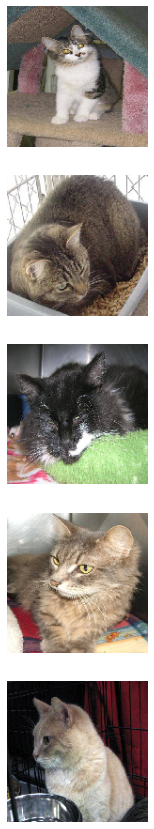

In [104]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.


In [105]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
    )

You don't have to do anything for the next cell. `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


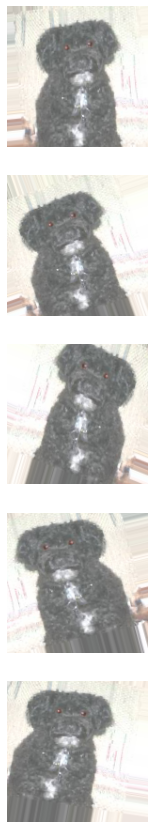

In [106]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [107]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 34, 34, 64)      

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [108]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch=total_train // batch_size,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
    )

Epoch 1/20
15/15 [==============================] - 63s 4s/step - loss: 0.7292 - accuracy: 0.5283 - val_loss: 0.6880 - val_accuracy: 0.5312
Epoch 2/20
15/15 [==============================] - 62s 4s/step - loss: 0.6836 - accuracy: 0.5694 - val_loss: 0.6716 - val_accuracy: 0.5982
Epoch 3/20
15/15 [==============================] - 62s 4s/step - loss: 0.6703 - accuracy: 0.5988 - val_loss: 0.6608 - val_accuracy: 0.6295
Epoch 4/20
15/15 [==============================] - 62s 4s/step - loss: 0.6626 - accuracy: 0.6138 - val_loss: 0.6387 - val_accuracy: 0.6964
Epoch 5/20
15/15 [==============================] - 62s 4s/step - loss: 0.6579 - accuracy: 0.6314 - val_loss: 0.6319 - val_accuracy: 0.6920
Epoch 6/20
15/15 [==============================] - 62s 4s/step - loss: 0.6406 - accuracy: 0.6506 - val_loss: 0.6257 - val_accuracy: 0.6339
Epoch 7/20
15/15 [==============================] - 62s 4s/step - loss: 0.6529 - accuracy: 0.6597 - val_loss: 0.7224 - val_accuracy: 0.5625
Epoch 8/20
15/15 [==

Run the next cell to visualize the accuracy and loss of the model.

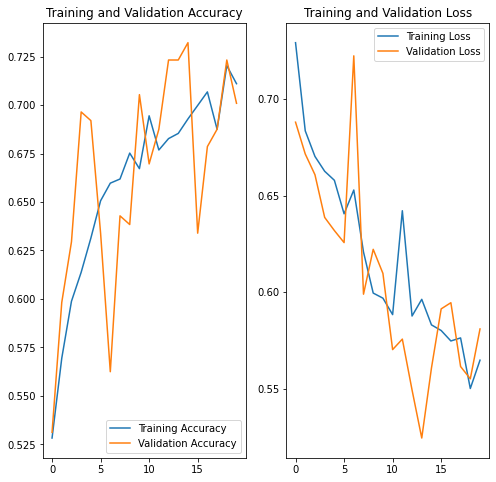

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

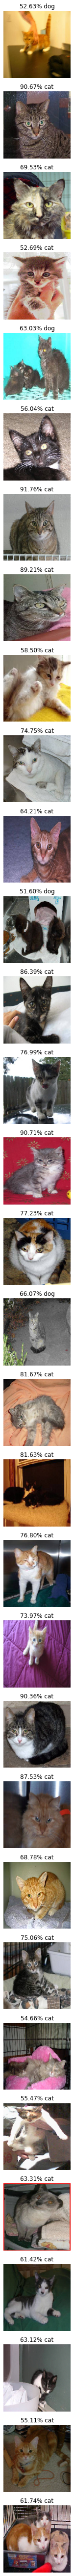

In [110]:
probabilities = model.predict(test_data_gen).tolist()
probabilities = list(map(lambda x: x[0], probabilities))
images, _ = next(test_data_gen)
plotImages(images, probabilities)

Run this final cell to see if you passed the challenge or if you need to keep trying.

In [111]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2):.0%} of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 58% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
